# Alternative probability representations

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.distribution import Distribution

import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## Original Plackett-Luce

In [2]:
from distributions import PlackettLuce

In [3]:
logits = torch.FloatTensor([1.0,0.0,0.0])
dist = PlackettLuce(logits)

In [4]:
samples = dist.sample(num_samples=100000)

In [5]:
pos = (F.one_hot(samples, samples.shape[-1]) * torch.arange(samples.shape[-1])[None,:,None]).sum(dim=-2)

In [6]:
samples[0]

tensor([0, 1, 2])

In [7]:
(F.one_hot(samples[0], samples.shape[-1]) * torch.arange(samples.shape[-1])[:,None]).sum(dim=-2)

tensor([0, 1, 2])

In [8]:
pos[0]

tensor([0, 1, 2])

In [9]:
(pos[...,None] > pos[:,None,:]).float()[0]

tensor([[0., 0., 0.],
        [1., 0., 0.],
        [1., 1., 0.]])

In [10]:
comp_matrix = (pos[:,None,:] > pos[...,None]).float()

In [11]:
comp_matrix.mean(dim=0)

tensor([[0.0000, 0.7305, 0.7293],
        [0.2695, 0.0000, 0.4993],
        [0.2707, 0.5007, 0.0000]])

In [12]:
torch.softmax(torch.stack([logits[None].expand(logits.shape[0],-1),
                           logits[...,None].expand(-1,logits.shape[0])], dim=-1), dim=-1)[...,1]

tensor([[0.5000, 0.7311, 0.7311],
        [0.2689, 0.5000, 0.5000],
        [0.2689, 0.5000, 0.5000]])

The experiment shows that $p(\pi_i > \pi_j)$ can be calculated as $\exp(\theta_i)/(\exp(\theta_i)+\exp(\theta_j))$

In [13]:
comp_matrix[torch.where(comp_matrix[:,0,1] == 1.0)].mean(dim=0)

tensor([[0.0000, 1.0000, 0.7863],
        [0.0000, 0.0000, 0.3935],
        [0.2137, 0.6065, 0.0000]])

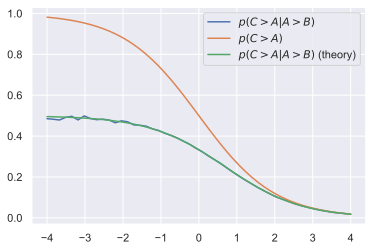

tensor([0.4955, 0.4947, 0.4937, 0.4926, 0.4914, 0.4899, 0.4881, 0.4860, 0.4836,
        0.4809, 0.4776, 0.4739, 0.4695, 0.4645, 0.4587, 0.4521, 0.4445, 0.4359,
        0.4263, 0.4154, 0.4033, 0.3899, 0.3753, 0.3594, 0.3423, 0.3241, 0.3051,
        0.2854, 0.2652, 0.2448, 0.2245, 0.2045, 0.1851, 0.1665, 0.1489, 0.1324,
        0.1171, 0.1031, 0.0904, 0.0789, 0.0687, 0.0596, 0.0515, 0.0444, 0.0383,
        0.0329, 0.0282, 0.0242, 0.0207, 0.0177])


In [72]:
def visualize_effect(values, idx_elem, start_elem=(0,1)):
    out_v, out_p, out_t = [], [], []
    for v in values:
        logits = torch.FloatTensor([v,0.0,0.0])
        dist = PlackettLuce(logits)
        samples = dist.sample(num_samples=200000)
        pos = (F.one_hot(samples, samples.shape[-1]) * torch.arange(samples.shape[-1])[None,:,None]).sum(dim=-2)
        comp_matrix = (pos[:,None,:] > pos[...,None]).float()
        out = comp_matrix[torch.where(comp_matrix[:,start_elem[0],start_elem[1]] == 1.0)].mean(dim=0)[idx_elem[0], idx_elem[1]]
        out_v.append(out)
        
        p = torch.softmax(torch.stack([logits[None].expand(logits.shape[0],-1),
                          logits[...,None].expand(-1,logits.shape[0])], dim=-1), dim=-1)[...,1]
        out_p.append(p[idx_elem[0], idx_elem[1]])
        
        theta = logits.exp()
        new_var = max(idx_elem)
        if start_elem[0] < start_elem[1]:
            p_C_A_B = theta[new_var] / (theta[start_elem[0]] + theta[start_elem[1]])
            p_A_C_gB_C = (1) / (1 + p_C_A_B)
            if idx_elem[0] > idx_elem[1]:
                p_A_C_gB_C = 1 - p_A_C_gB_C
            out_t.append(p_A_C_gB_C)
        else:
            frac_A_B_C = theta[new_var] * (theta[start_elem[1]] + theta[new_var]) / (theta[start_elem[1]] + theta[start_elem[0]])
            p_B_A_C = theta[start_elem[1]] / (theta[start_elem[1]] + theta[new_var] + frac_A_B_C)
            if idx_elem[0] > idx_elem[1]:
                p_B_A_C = 1 - p_B_A_C
            out_t.append(p_B_A_C)
        
    sns.set()
    names = ["A","B","C","D","E","F"]
    c1 = names[idx_elem[0]] + ">" + names[idx_elem[1]]
    c2 = names[start_elem[0]] + ">" + names[start_elem[1]]
    plt.plot(values, out_v, label=r"$p(%s|%s)$" % (c1,c2))
    plt.plot(values, out_p, label=r"$p(%s)$" % (c1))
    plt.plot(values, out_t, label=r"$p(%s|%s)$ (theory)" % (c1,c2))
    plt.legend()
    plt.show()
    plt.close()
    
visualize_effect(np.linspace(start=-4,stop=4,num=50), idx_elem=(2,0))

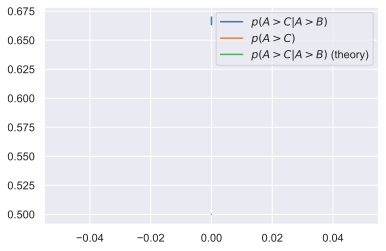

tensor([0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667,
        0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667,
        0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667,
        0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667,
        0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667,
        0.6667, 0.6667, 0.6667, 0.6667, 0.6667])


In [76]:
visualize_effect(np.linspace(start=-4,stop=4,num=50), idx_elem=(0,2), start_elem=(0,1))

## Partial comparisons

$$p(X_i=A|X_{1,...i-1})=\prod_{Y\not\in X_{1,...,i-1}} p(A>Y)$$

In [2]:
def create_triangle_mask(num_vars):
    xx, yy = torch.meshgrid(torch.arange(num_vars), torch.arange(num_vars))
    mask = (xx < yy).float()
    return mask

create_triangle_mask(num_vars=3)

tensor([[0., 1., 1.],
        [0., 0., 1.],
        [0., 0., 0.]])

In [3]:
def logits_to_probs(logits, triangle_mask=None):
    if triangle_mask is None:
        triangle_mask = create_triangle_mask(logits.shape[-1])
    while len(logits.shape) > len(triangle_mask.shape):
        triangle_mask = triangle_mask.unsqueeze(dim=0)
    probs = torch.sigmoid(logits)
    probs = triangle_mask * probs + triangle_mask.transpose(-1,-2) * (1 - probs.transpose(-1,-2))
    probs[...,torch.arange(probs.shape[-2]), torch.arange(probs.shape[-1])] = 1.0
    return probs

logits_to_probs(logits=torch.randn(1, 4, 4))

tensor([[[1.0000, 0.5654, 0.4510, 0.5214],
         [0.4346, 1.0000, 0.6244, 0.6246],
         [0.5490, 0.3756, 1.0000, 0.3646],
         [0.4786, 0.3754, 0.6354, 1.0000]]])

In [4]:
class PartialComparisonDist(Distribution):
    
    def __init__(self, logits):
        super().__init__()
        self.logits = logits
        self.num_vars = self.logits.shape[0]
        
    def sample(self, num_samples):
        logits = self.logits[None].repeat(num_samples, 1, 1)
        samples = torch.zeros(num_samples, 0)
        with torch.no_grad():
            for _ in range(self.num_vars):
                prob_matrix = logits_to_probs(logits)
                logprobs = torch.log(prob_matrix).sum(dim=-1)
                probs = torch.softmax(logprobs, dim=-1)
                # print("Probs", probs)
                s = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
                # print(s.shape, samples.shape)
                samples = torch.cat([samples, s[:,None]], dim=1)
                logits[torch.arange(s.shape[0]), :, s] = 9e15
                logits[torch.arange(s.shape[0]), s, :] = -9e15
                # print("Logits", logits)
        return samples

In [5]:
dist = PartialComparisonDist(logits=torch.randn(4, 4))
dist.sample(num_samples=16)

tensor([[2., 1., 3., 0.],
        [3., 2., 0., 1.],
        [3., 2., 0., 1.],
        [3., 2., 0., 1.],
        [2., 0., 3., 1.],
        [2., 3., 0., 1.],
        [2., 3., 0., 1.],
        [2., 3., 0., 1.],
        [3., 2., 0., 1.],
        [1., 2., 3., 0.],
        [0., 2., 1., 3.],
        [2., 3., 0., 1.],
        [3., 2., 0., 1.],
        [0., 1., 2., 3.],
        [3., 2., 0., 1.],
        [2., 0., 3., 1.]])

In [6]:
dist_probs = torch.FloatTensor([[0.0, 0.4, 1.0, 0.8],
                                [0.0, 0.0, 1.0, 1.0],
                                [0.0, 0.0, 0.0, 0.4],
                                [0.0, 0.0, 0.0, 0.0]])
dist_probs = torch.distributions.utils.clamp_probs(dist_probs)
logits = torch.log(dist_probs) - torch.log(1 - dist_probs)
dist.logits = logits
dist.sample(num_samples=16)

tensor([[1., 0., 3., 2.],
        [1., 0., 2., 3.],
        [1., 3., 0., 2.],
        [1., 0., 2., 3.],
        [0., 1., 3., 2.],
        [1., 3., 0., 2.],
        [0., 1., 3., 2.],
        [1., 0., 3., 2.],
        [1., 0., 3., 2.],
        [0., 1., 2., 3.],
        [0., 1., 3., 2.],
        [0., 1., 3., 2.],
        [1., 0., 3., 2.],
        [1., 0., 3., 2.],
        [0., 1., 2., 3.],
        [1., 3., 0., 2.]])

## Autoregressive Plackett-Luce

In [72]:
class PlackettLuceAutoreg(Distribution):
    """
        Plackett-Luce distribution
    """

    def __init__(self, num_vars, nn):
        super(PlackettLuceAutoreg, self).__init__()
        self.num_vars = num_vars
        self.nn = nn

    def sample(self, num_samples):
        # sample permutations using Gumbel-max trick to avoid cycles
        samples = torch.zeros(num_samples, 0, dtype=torch.long)
        inputs = torch.zeros(num_samples, self.num_vars)
        with torch.no_grad():
            for _ in range(self.num_vars):
                preds = self.nn(inputs)
                preds.masked_fill_(inputs == 1.0, -9e15)
                probs = torch.softmax(preds, dim=-1)
                s = torch.multinomial(probs, num_samples=1)
                samples = torch.cat([samples, s], dim=1)
                inputs[torch.arange(num_samples), s.squeeze(dim=1)] = 1.0
        return samples

    def log_prob(self, samples):
        assert len(samples.shape) == 2
        # Input preparation
        with torch.no_grad():
            inputs = samples.new_zeros(self.num_vars-1, *samples.shape, dtype=torch.float32)
            for i in range(self.num_vars-1):
                inputs[i, torch.arange(samples.shape[0]), samples[:,i]] = 1.0
            inputs = torch.cumsum(inputs, dim=0)
            
        # Probability of first variable
        first_params = self.nn(inputs.new_zeros(1, self.num_vars))
        first_params = F.log_softmax(first_params, dim=-1)
        logits = first_params[0,samples[:,0]]
        
        # Probability of all other variables
        preds = self.nn(inputs)
        preds.masked_fill_(inputs == 1.0, -9e15)
        preds = preds.reshape(-1, self.num_vars)
        labels = samples[:,1:].permute(1, 0).reshape(-1)
        logits_nn = -F.cross_entropy(preds, labels, reduction="none")
        logits_nn = logits_nn.reshape(samples.shape[1] - 1, samples.shape[0]) # Preds are permuted in dimensions
        logits = logits + logits_nn.sum(dim=0)
        
        return logits

In [73]:
class SimpleNN(nn.Module):
    
    def __init__(self, num_vars, hidden_size=64):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_vars, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, num_vars)
        )
    
    def forward(self, x):
        return self.layers(x)

In [74]:
NUM_VARS = 4
network = SimpleNN(num_vars=NUM_VARS)
dist = PlackettLuceAutoreg(num_vars=NUM_VARS, nn=network)
samples = dist.sample(num_samples=16)

In [75]:
dist.log_prob(samples)

tensor([-3.4566, -3.4566, -2.9839, -2.9839, -3.0011, -2.9877, -3.3068, -3.3068,
        -3.0187, -3.1787, -3.4121, -3.1713, -3.0187, -3.0904, -3.2235, -2.9705],
       grad_fn=<AddBackward0>)

In [76]:
dataset = torch.LongTensor([[0, 1, 2, 3],
                            [1, 0, 2, 3],
                            [0, 1, 3, 2],
                            [1, 0, 3, 2],
                            [1, 3, 0, 2]])
print("Before training", dist.log_prob(dataset))

optim = torch.optim.Adam(network.parameters(), lr=1e-2)
for _ in range(1000):
    ll = dist.log_prob(dataset)
    optim.zero_grad()
    (-ll).sum().backward()
    optim.step()
print("After training", dist.log_prob(dataset))

Before training tensor([-3.3068, -3.4121, -3.5420, -3.6473, -3.5197], grad_fn=<AddBackward0>)
After training tensor([-1.6095, -1.6094, -1.6096, -1.6095, -1.6097], grad_fn=<AddBackward0>)


In [78]:
dist.log_prob(torch.LongTensor([[1, 2, 0, 3]]))

tensor([-11.2205], grad_fn=<AddBackward0>)